<a href="https://colab.research.google.com/github/Chiebukar/Deep-Learning/blob/main/skin_cancer_images_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binary classification of skin cancer into malignant or beningn classes with convolutional neural network

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s cancer

In [4]:
# Download Dataset
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign 

 94% 304M/325M [00:03<00:00, 89.4MB/s]
100% 325M/325M [00:03<00:00, 104MB/s] 


In [5]:
# View downloaded files
!ls -d $PWD/*

/content/kaggle.json  /content/skin-cancer-malignant-vs-benign.zip
/content/sample_data


In [ ]:
# Unzip files
!unzip \*.zip && rm *.zip

In [7]:
# view unzipped files
!ls -d $PWD/*

/content/data	      /content/sample_data  /content/train
/content/kaggle.json  /content/test


In [8]:
# show subfolders of train and test folders
!ls -d $PWD/train/*
!ls -d $PWD/test/*

/content/train/benign  /content/train/malignant
/content/test/benign  /content/test/malignant


In [9]:
# get train and test files path
train_file_path = '/content/train/'
test_file_path = '/content/test/'

In [10]:
# import required libraries
import os
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [11]:
#  show folders in train folders
os.listdir('/content/train/')

['malignant', 'benign']

In [12]:
# show folder in test folder
os.listdir(test_file_path)

['malignant', 'benign']

In [13]:
# load images into features and labels
def load_images(path):
  features = []
  targets = []
  labels = os.listdir(path)
  for label in labels:
    label_path = path + '{}/'.format(label)
    img_dirs = os.listdir(label_path)
    num = len(img_dirs)
    print('There are {} images in {} folder'.format(num,label))
    print('Loading images into features and labels set...')
    for dir in img_dirs:
      img_path = label_path + dir
      image = cv2.imread(img_path)
      resized_image = cv2.resize(image, (224,224))
      features.append(np.array(resized_image))
      targets.append(label)
  print('Completed loading images')
  return features, targets

In [14]:
train_data, train_labels = load_images(train_file_path)

There are 1197 images in malignant folder
Loading images into features and labels set...
There are 1440 images in benign folder
Loading images into features and labels set...
Completed loading images


In [15]:
test_data, test_labels = load_images(test_file_path)

There are 300 images in malignant folder
Loading images into features and labels set...
There are 360 images in benign folder
Loading images into features and labels set...
Completed loading images


In [16]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [17]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((2637, 224, 224, 3), (2637,), (660, 224, 224, 3), (660,))

In [18]:
# to display the first image in each label
def display_image(path):
  labels = os.listdir(path)
  for label in labels:
    label_path = (path + '{0}/').format(label)
    imgs_path = os.listdir(label_path)
    print(label)
    img_path = label_path+imgs_path[0]
    display(Image(img_path))

malignant


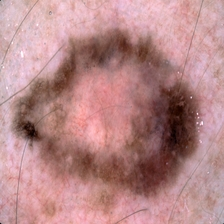

benign


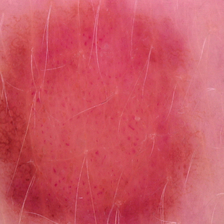

In [19]:
# display image from labels
display_image(train_file_path)

In [20]:
# normalise the features
train_data = train_data/255
test_data = test_data/255

In [21]:
from sklearn.utils import shuffle

In [22]:
# shuffle train sets
train_data, train_labels = shuffle(train_data, train_labels, random_state = 0, stratify = train_labels)

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
# encode targets to numerical values
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
train_labels[:5]

test_labels = encoder.fit_transform(test_labels)
test_labels[:5]

array([1, 1, 1, 1, 1])

In [25]:
# one hot encoding for labels
from keras.utils.np_utils import to_categorical

In [26]:
train_labels = to_categorical(train_labels, num_classes= 2)
test_labels = to_categorical(test_labels, num_classes= 2)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# split training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size= 0.2)

In [29]:
# View shape of the training and validation sets
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((2109, 224, 224, 3), (2109, 2), (528, 224, 224, 3), (528, 2))

In [30]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
# Define image data generator
batch_size =16
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   zoom_range = 2,
                                   horizontal_flip=True,
                                   vertical_flip = True)

In [32]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [33]:
# build CNN model

def build_model():
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape= x_train.shape[1:]))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D(2,2))

  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(units=128, activation='relu'))

  model.add(Dense(units=64, activation='relu'))

  model.add(Dense(units=8, activation='relu'))

  model.add(Dense(units=2, activation='softmax'))

  model.compile(loss= 'binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

  model.summary()

  return model


In [34]:
# learning rate reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose = 1, factor= 0.2, min_lr = 1e-7)

# checkpoint
filepath=('a_weights.best.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# fit model 
batch_size =16
model = build_model()
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch= (x_train.shape[0]/batch_size),
                    epochs= 25, validation_data = (x_val, y_val),
                    callbacks= [learn_control, checkpoint])

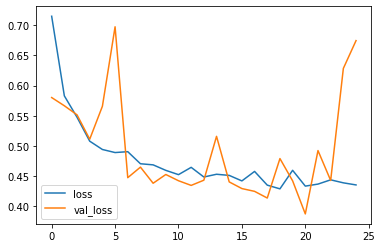

In [43]:
# Visualize model performance 
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

Model Testing and evaluation

In [37]:
# load best weight
model.load_weights('a_weights.best.hdf5')

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
# show model accuracy on validation set
y_val_pred = model.predict(x_val)
val_accuracy  = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis = 1))
print('Validation accuracy score: {}'.format(val_accuracy))

Validation accuracy score: 0.8238636363636364


In [40]:
# show model accuracy on test set
y_test_pred = model.predict(test_data)
test_accuracy  = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_test_pred, axis =1))
print('Test accuracy score: {}'.format(test_accuracy))

Test accuracy score: 0.8227272727272728


Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix

([<matplotlib.axis.YTick at 0x7fd87e43c050>,
 [Text(0, 0.5, 'malignant'), Text(0, 1.5, 'benign')])

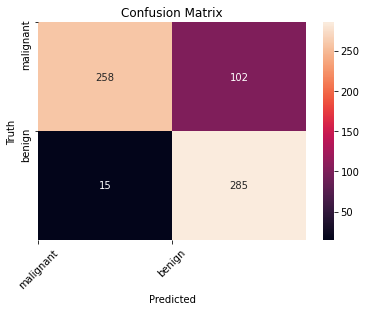

In [46]:
# visualize confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(y_test_pred, axis =1))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title ('Confusion Matrix')

labels = os.listdir(test_file_path)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

Classification Report

In [47]:
from sklearn.metrics import classification_report

In [49]:
# display classification report
classification_report(np.argmax(test_labels, axis=1), np.argmax(y_test_pred, axis =1))

'              precision    recall  f1-score   support\n\n           0       0.95      0.72      0.82       360\n           1       0.74      0.95      0.83       300\n\n    accuracy                           0.82       660\n   macro avg       0.84      0.83      0.82       660\nweighted avg       0.85      0.82      0.82       660\n'

Stacking a pretrained CNN base with dense layer

In [54]:
# import pretrained model
from keras.applications import DenseNet201

In [55]:
conv_base = DenseNet201(weights= 'imagenet', include_top=False, input_shape=  (224, 224,3))

74842112/74836368 [==============================] - 0s 0us/step


In [56]:
# build dense neural network layer
def build_model(base):
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(2, activation='softmax'))

  model.compile(loss= 'binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
  return model

In [57]:
# learning rate reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose = 1, factor= 0.2, min_lr = 1e-7)

# checkpoint
filepath=('b_weights.best.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# stack CNN and Dense layers, fit model
model = build_model(conv_base)
batch_size =16
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch= (x_train.shape[0]/batch_size),
                    epochs= 25, validation_data = (x_val, y_val),
                    callbacks= [learn_control, checkpoint])

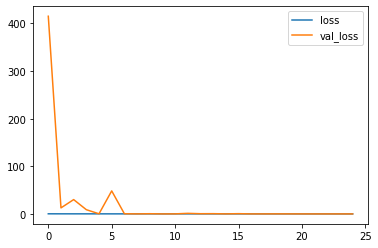

In [59]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

Model Testing and evaluation

In [60]:
model.load_weights('b_weights.best.hdf5')

In [61]:
from sklearn.metrics import accuracy_score

In [62]:
score = model.evaluate(x_val, y_val)

17/17 [==============================] - 1s 86ms/step - loss: 0.3504 - acc: 0.8542


In [63]:
y_val_pred = model.predict(x_val)
val_accuracy  = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis = 1))
print('Validation accuracy score: {}'.format(val_accuracy))

Validation accuracy score: 0.8541666666666666


In [64]:
y_test_pred = model.predict(test_data)
test_accuracy  = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(y_test_pred, axis =1))
print('Test accuracy score: {}'.format(test_accuracy))

Test accuracy score: 0.8484848484848485


Using Pretrained Model for feature extraction

In [65]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((2109, 224, 224, 3), (2109, 2), (528, 224, 224, 3), (528, 2))

In [66]:
test_data.shape, test_labels.shape

((660, 224, 224, 3), (660, 2))

In [67]:
from keras.applications import DenseNet201

In [68]:
input_shape = x_train.shape[1:]
conv_base = DenseNet201(weights = 'imagenet', input_shape= input_shape, include_top = False)
conv_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [69]:
# Define image data generator
conv_base_shape = (7,7,1920)
datagen = ImageDataGenerator(rotation_range = 90,
                                   zoom_range = 2,
                                   horizontal_flip=True,
                                   vertical_flip = True)

In [70]:
def feature_extraction(data, sample_count, batch_size=9):
  features = np.zeros(shape= (sample_count, 7, 7, 1920))
  labels = np.zeros(shape= sample_count)
  generator = datagen.flow(data, batch_size= batch_size)
  
  i = 0
  for input_batch, label_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i*batch_size: (i+1) * batch_size] = features_batch
    labels[i*batch_size: (i+1) * batch_size] = label_batch
    i += 1
    if i*batch_size >= sample_count:
      break
  return features, labels

In [71]:
len_train = x_train.shape[0]
len_val = x_val.shape[0]
len_test = test_data.shape[0]

In [74]:
y_train = np.argmax(y_train, axis = 1)
y_val = np.argmax(y_val, axis=1)
test_labels = np.argmax(test_labels, axis = 1)

In [80]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((2109, 224, 224, 3), (2109,), (528, 224, 224, 3), (528,))

In [75]:
train_data, train_labels = feature_extraction((x_train, y_train), len_train)
val_data, val_labels = feature_extraction((x_val, y_val), len_val)
test_data, test_labels = feature_extraction((test_data, test_labels), len_test)

In [76]:
# flattening the extracted features
train_data = np.reshape(train_data, (len_train, 7 * 7 * 1920))
val_data = np.reshape(val_data, (len_val, 7 * 7 * 1920))
test_data = np.reshape(test_data, (len_test, 7 * 7 * 1920))

In [84]:
# build CNN model

def build_model():
  model = Sequential()

  model.add(Dense(units=512, activation='relu', input_dim= 7 * 7 * 1920 ))

  model.add(Dropout(0.25))

  model.add(Dense(units=256, activation='relu'))

  model.add(Dropout(0.25))

  model.add(Dense(units=32, activation='relu'))

  model.add(Dropout(0.25))

  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss= 'binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

  model.summary()

  return model


In [82]:
# learning rate reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose = 1, factor= 0.2, min_lr = 1e-7)

# checkpoint
filepath=('c_weights.best.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# fit model
batch_size = 9
model = build_model()
history = model.fit(train_data, train_labels, epochs= 25, validation_data = (val_data, val_labels),
                    batch_size = batch_size, callbacks= [learn_control, checkpoint])

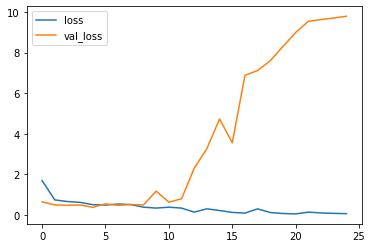

In [86]:
# visualize model performance
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

Model Testing and evaluation

In [87]:
# save model
model.load_weights('c_weights.best.hdf5')

In [88]:
from sklearn.metrics import accuracy_score

In [92]:
# Evaluate model performance on valiation data
val_accuracy = model.evaluate(val_data, val_labels)
print('Validation accuracy score: {}'.format(val_accuracy))

17/17 [==============================] - 0s 5ms/step - loss: 0.4825 - acc: 0.8485
Validation accuracy score: [0.48251256346702576, 0.8484848737716675]


In [93]:
# Evaluate model performance on valiation data
test_accuracy  = model.evaluate(test_data, test_labels)
print('Test accuracy score: {}'.format(test_accuracy))

21/21 [==============================] - 0s 5ms/step - loss: 0.6446 - acc: 0.8076
Test accuracy score: [0.6446343660354614, 0.8075757622718811]
